In [105]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import pandas as pd

In [106]:
file_path_test = r"D:\ki 4\AIL303M\dự án\buzz 1\Test\None_swarming\bee sound\126173_B00005_Thu Apr 04 2024_1.wav" 
if not os.path.exists(file_path_test):
    raise FileNotFoundError(f"File not found: {file_path_test}")

y, sr = librosa.load(file_path_test, sr=None)

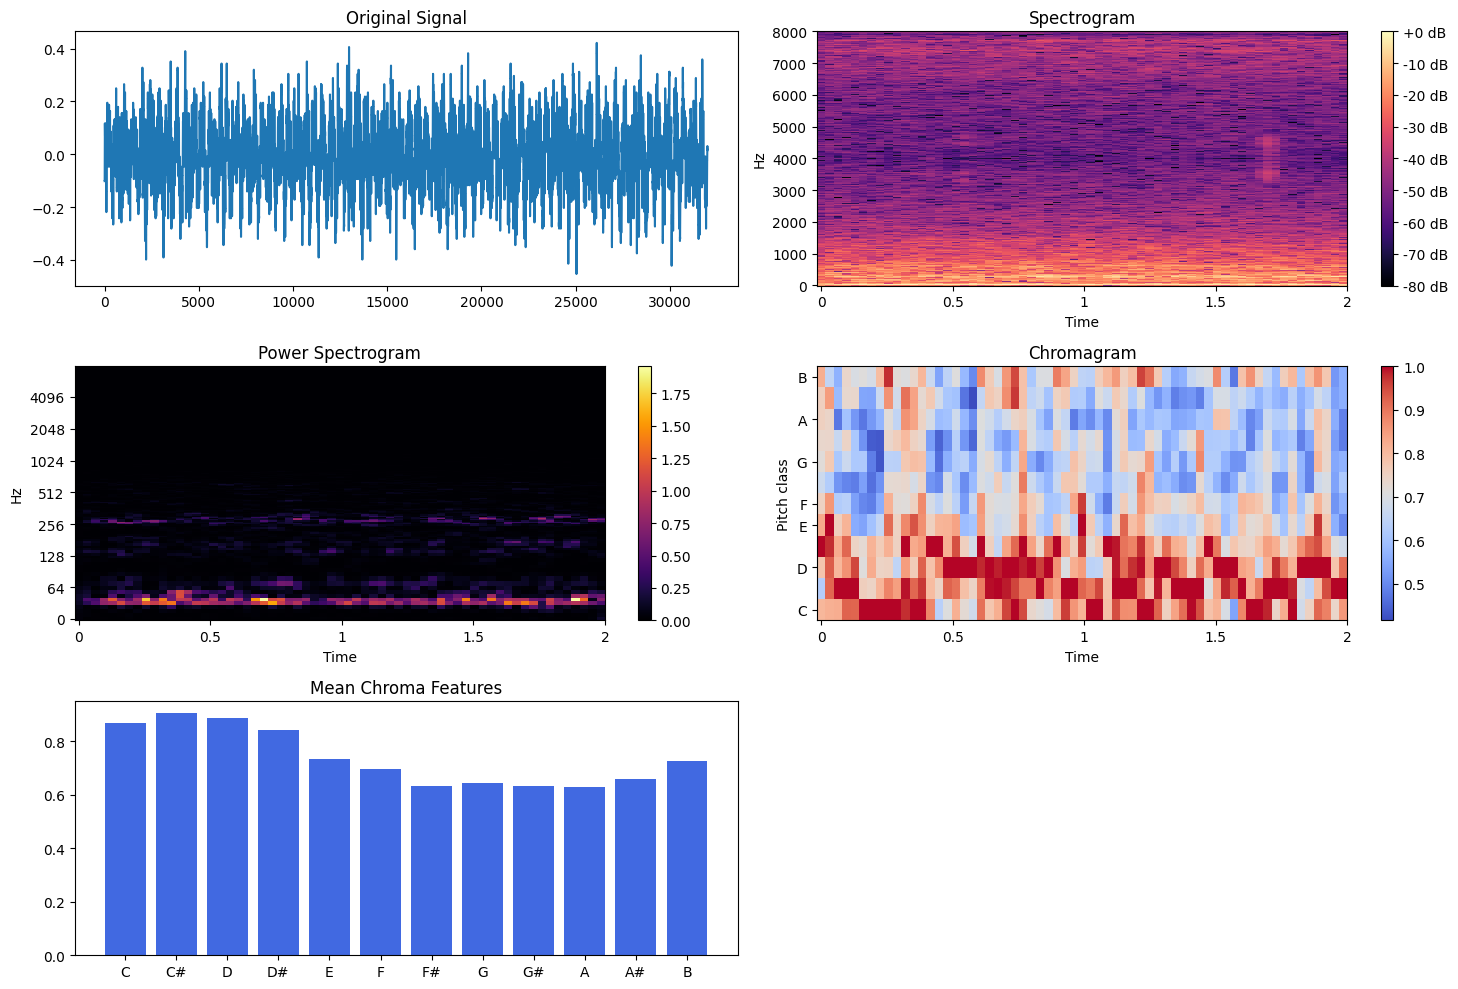

In [107]:
window_size = 2048
hop_length = 512

D = librosa.stft(y, n_fft=window_size, hop_length=hop_length)

magnitude_spectrogram = np.abs(D)

D_db = librosa.amplitude_to_db(magnitude_spectrogram, ref=np.max)

power_spectrogram = (magnitude_spectrogram ** 2) / window_size

chromagram = librosa.feature.chroma_stft(S=np.abs(D), sr=sr, hop_length=hop_length)

mean_chroma = np.mean(chromagram, axis=1)

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.plot(y)
plt.title("Original Signal")

plt.subplot(3, 2, 2)
librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")

plt.subplot(3, 2, 3)
librosa.display.specshow(power_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar()
plt.title("Power Spectrogram")

plt.subplot(3, 2, 4)
librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chromagram")

plt.subplot(3, 2, 5)
plt.bar(range(12), mean_chroma, color='royalblue')
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.title("Mean Chroma Features")

plt.tight_layout()
plt.show()


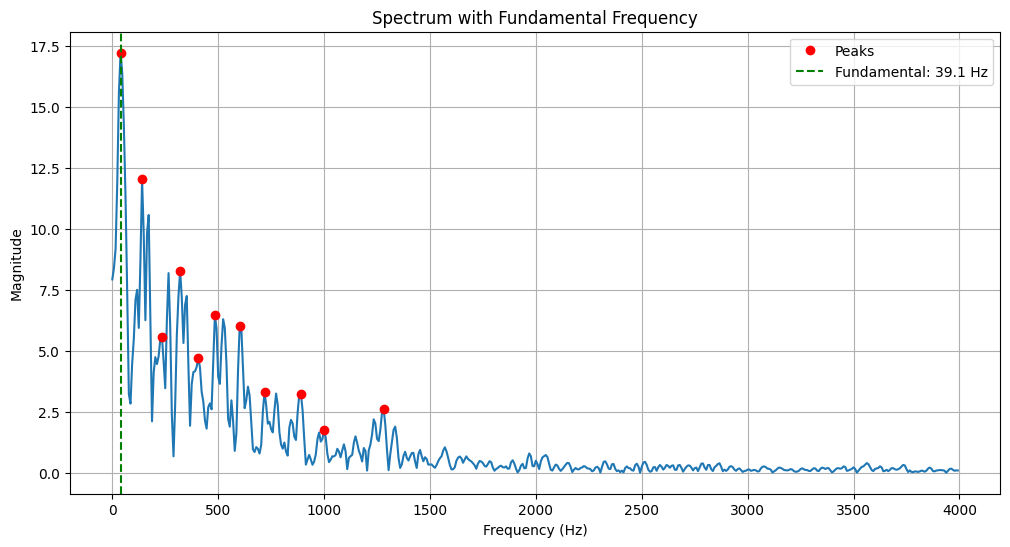

Estimated fundamental frequency: 39.1 Hz


In [108]:
spectrum = np.abs(D[:, 0])
frequencies = librosa.fft_frequencies(sr=sr, n_fft=window_size)

peaks, properties = find_peaks(spectrum, height=np.max(spectrum)*0.1, distance=10)

peak_freqs = frequencies[peaks]
peak_amplitudes = spectrum[peaks]

mask = peak_freqs < 1000
fundamental_candidates = peak_freqs[mask]
candidate_amplitudes = peak_amplitudes[mask]

if len(fundamental_candidates) > 0:
    fundamental_idx = np.argmax(candidate_amplitudes)
    fundamental_freq = fundamental_candidates[fundamental_idx]

    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(spectrum)//2], spectrum[:len(spectrum)//2])
    plt.plot(peak_freqs, peak_amplitudes, 'ro', label='Peaks')
    plt.axvline(x=fundamental_freq, color='g', linestyle='--', 
                label=f'Fundamental: {fundamental_freq:.1f} Hz')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Spectrum with Fundamental Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Estimated fundamental frequency: {fundamental_freq:.1f} Hz")
else:
    print("No clear fundamental frequency found")


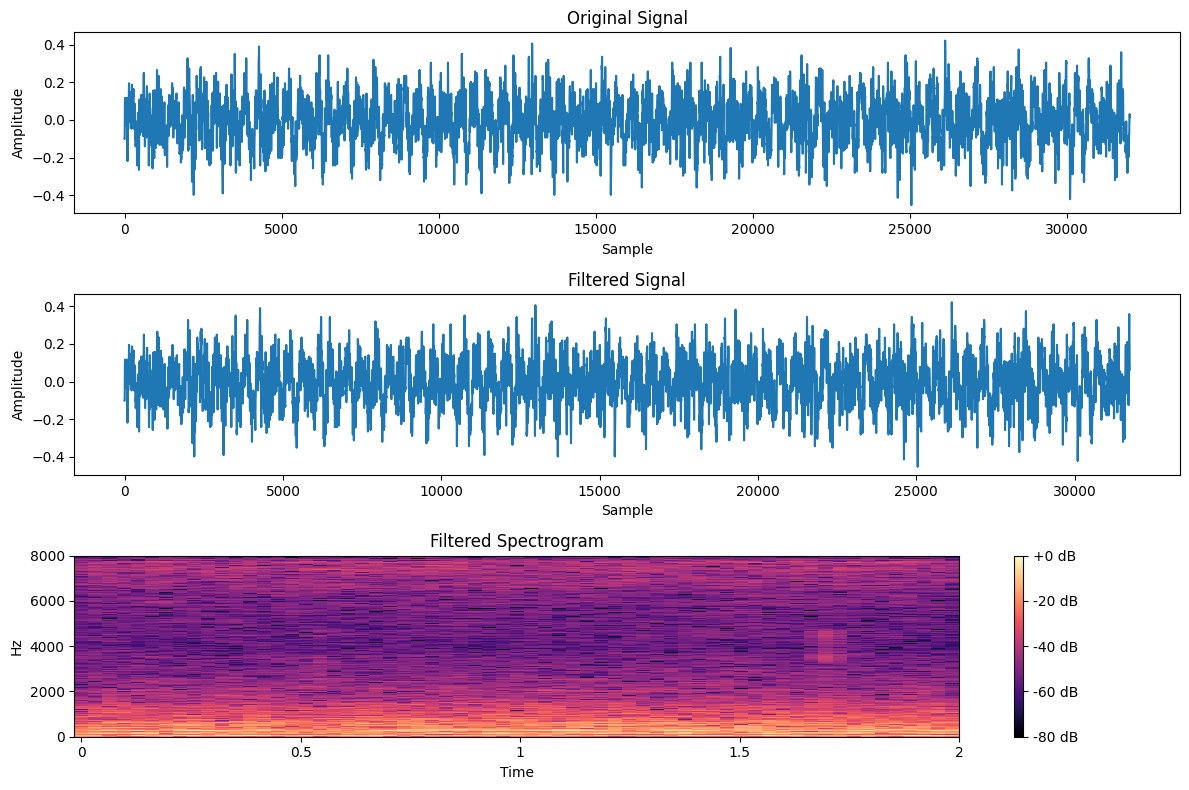

In [ ]:
#lọc tần số
lowcut = 100  # Lower frequency cutoff
highcut = 5000  # Upper frequency cutoff

# Apply bandpass filter using the frequency response from STFT
# tạo mặt na tần số
freqs = librosa.fft_frequencies(sr=sr, n_fft=window_size)
mask = (freqs >= lowcut) & (freqs <= highcut)
#áp dụng cho cả âm và dương
freq_mask = np.zeros_like(D)
freq_mask[mask, :] = 1
freq_mask[~mask, :] = 1 

# bộ lọc tần số
D_filtered = D * freq_mask

# chuyển đổi miền thời gian
y_filtered = librosa.istft(D_filtered, hop_length=hop_length)

# Plot original and filtered signals
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('Original Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(y_filtered)
plt.title('Filtered Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot frequency response
plt.subplot(3, 1, 3)
filtered_spectrum = np.abs(librosa.stft(y_filtered, n_fft=window_size, hop_length=hop_length))
librosa.display.specshow(librosa.amplitude_to_db(filtered_spectrum, ref=np.max), 
                        y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered Spectrogram')

plt.tight_layout()
plt.show()

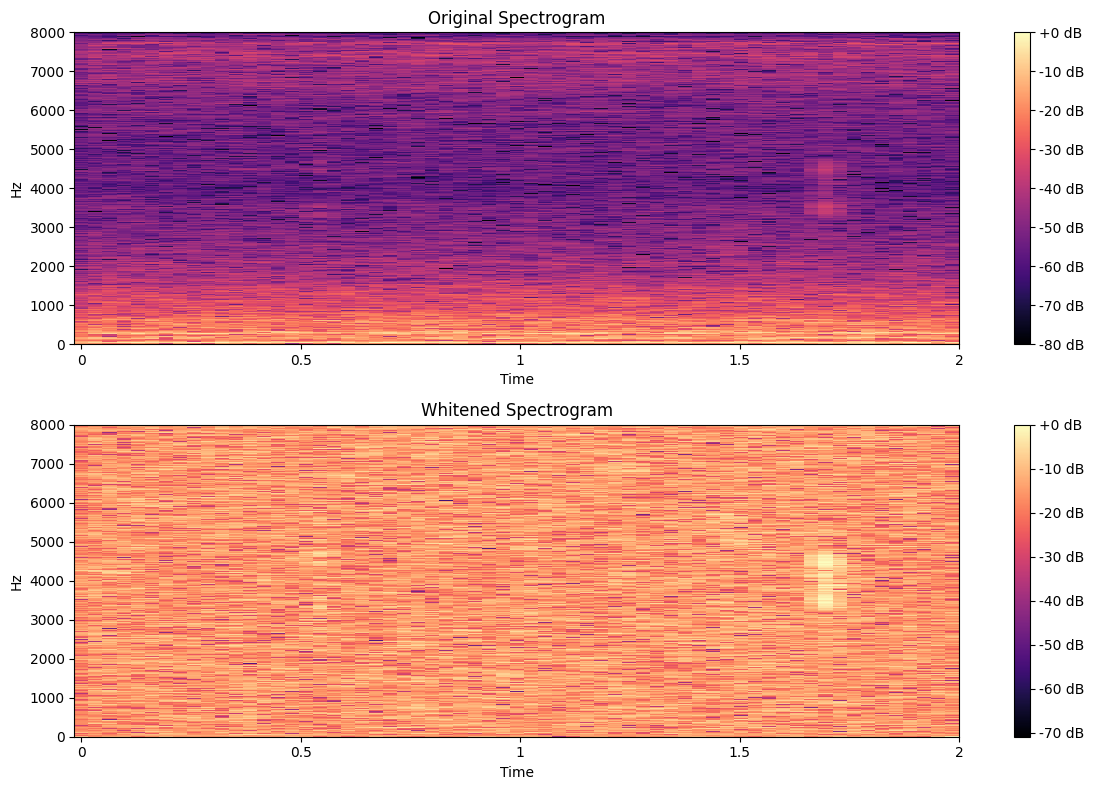

In [110]:
# Spectral whitening
# Calculate mean spectrum across time
mean_spectrum = np.mean(np.abs(D), axis=1, keepdims=True)
eps = 1e-6  # Small constant to avoid division by zero

# Normalize the spectrogram by the mean spectrum
whitened_spectrogram = np.abs(D) / (mean_spectrum + eps)

# Convert to dB scale
whitened_db = librosa.amplitude_to_db(whitened_spectrogram, ref=np.max)

# Plot original and whitened spectrograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, 
                        x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(whitened_db, sr=sr, hop_length=hop_length, 
                        x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Whitened Spectrogram')

plt.tight_layout()
plt.show()

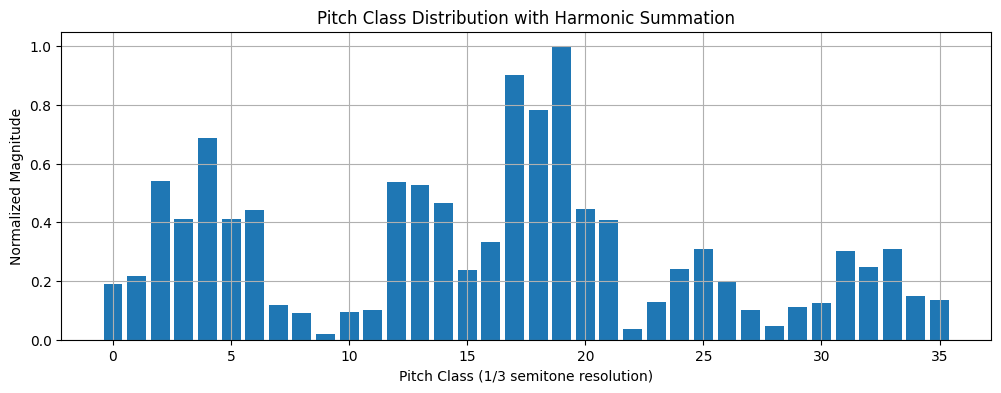

In [111]:
# tạo 36 bins cho phân phối lớp pitch
n_bins = 36
pitch_class_dist = np.zeros(n_bins)
n_harmonics = 8

# Convert frequencies to pitch classes using the reference frequency
def freq_to_pitch_class(freq, reference=440.0):
    if freq <= 0:
        return 0
    return 12 * np.log2(freq / reference) % 12

# Weight function using cosine
def weight_function(x):
    return np.cos(np.pi * x / 2) if abs(x) <= 1 else 0

# Process each peak frequency with its harmonics
for freq, mag in zip(peak_freqs, peak_amplitudes):
    for h in range(1, n_harmonics + 1):
        harmonic_freq = freq * h
        if harmonic_freq >= sr/2:  # Skip if above Nyquist frequency
            continue
            
        # Get pitch class for the harmonic
        pitch = freq_to_pitch_class(harmonic_freq)
        
        # Convert to fine resolution (36 bins)
        fine_pitch = pitch * 3
        
        # Add weighted contribution to neighboring bins
        for i in range(-1, 2):
            bin_index = int(round(fine_pitch + i)) % n_bins
            weight = weight_function(i/3.0)  # Weight based on distance
            pitch_class_dist[bin_index] += mag * weight / h  # Weight by harmonic number

# Normalize the distribution
pitch_class_dist = pitch_class_dist / np.max(pitch_class_dist)

# Plot the pitch class distribution
plt.figure(figsize=(12, 4))
plt.bar(np.arange(n_bins), pitch_class_dist)
plt.xlabel('Pitch Class (1/3 semitone resolution)')
plt.ylabel('Normalized Magnitude')
plt.title('Pitch Class Distribution with Harmonic Summation')
plt.grid(True)
plt.show()

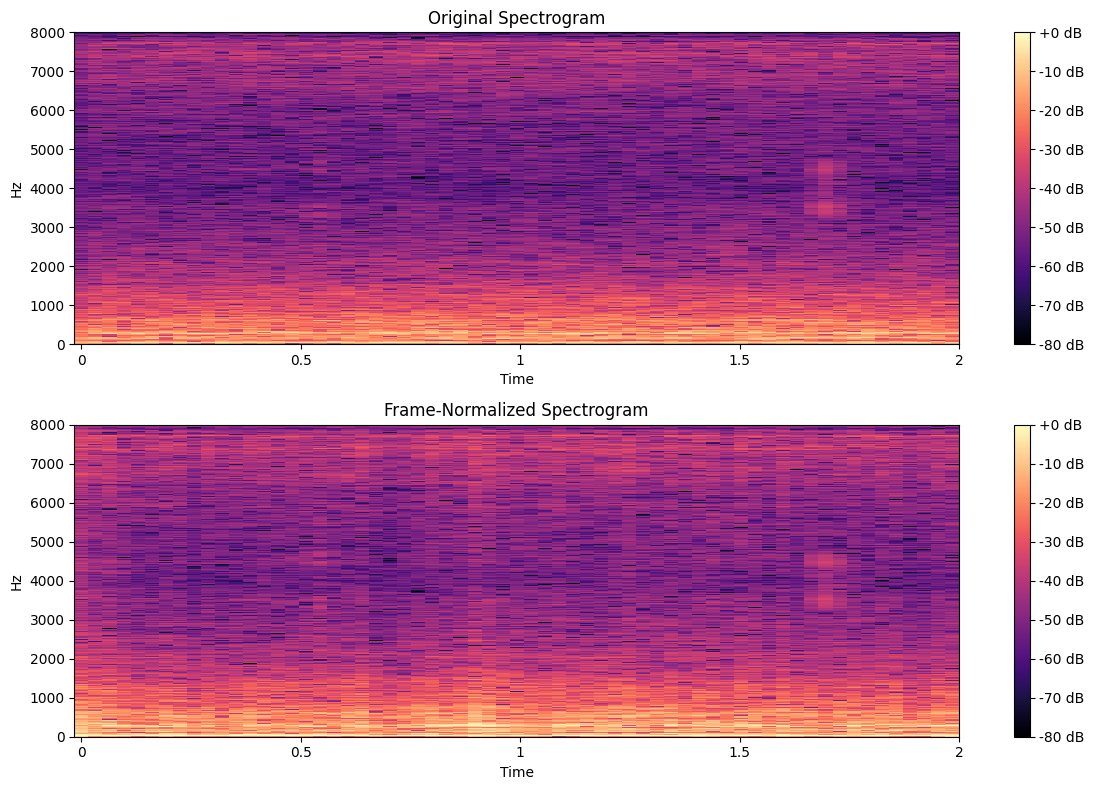

In [112]:
# Get the magnitude spectrum frame by frame and normalize
n_frames = magnitude_spectrogram.shape[1]
normalized_spectrogram = np.zeros_like(magnitude_spectrogram)

for frame_idx in range(n_frames):
    frame = magnitude_spectrogram[:, frame_idx]
    max_val = np.max(frame)
    if max_val > eps:  # Avoid division by zero
        normalized_spectrogram[:, frame_idx] = frame / max_val

# Plot original vs normalized spectrograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude_spectrogram, ref=np.max),
                        sr=sr, hop_length=hop_length,
                        x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(normalized_spectrogram, ref=np.max),
                        sr=sr, hop_length=hop_length,
                        x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Frame-Normalized Spectrogram')

plt.tight_layout()
plt.show()